In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from collections import Counter
import time

import sys, os

sys.path.append(os.path.abspath("../../src"))

from SegLabel import SegLabel
from dwave_utils import plot_qubo_matrix

from dimod import BinaryQuadraticModel
from tabu import TabuSampler

%load_ext lab_black

In [2]:
from docplex.mp.model import Model


def build_qubo_matrix(mdl: Model, norm: bool = True):
    """Extract the QUBO matrix and optionally normalize it."""
    Q = dict()
    Q.update(
        {
            (a.index, b.index): coef
            for a, b, coef in mdl.objective_expr.iter_quad_triplets()
        }
    )
    for a, coef in mdl.objective_expr.iter_terms():
        key = (a.index, a.index)
        if key in Q:
            Q[key] += coef
        else:
            Q[key] = coef
    offset = mdl.objective_expr.constant

    if norm:
        weights = np.unique(np.abs(list(Q.values())))
        max_w = np.max(weights)
        # print(max_w)
        for key in Q.keys():
            Q[key] /= max_w
        offset /= max_w

    return Q, offset

## Model

In [3]:
from SegmentationAndLabeling_NEW_VERSION import SegmentationAndLabeling

# read the data
with open("024185229_hipsterDoubleHead_SegLabelData.pickle", "rb") as f:
    segLabel = pickle.load(f)

# beta_dc_d'c'u
B = segLabel.betas.copy()
B = np.nan_to_num(B, nan=0.0)
B_max = np.max(B)

print("B:")
print("  shape: ", np.shape(B))
print("  min/max: ", np.min(B), B_max)

# alpha_dc
A = segLabel.alphas.copy()
A = np.nan_to_num(A, nan=0.0)
A_max = B_max
A[A > A_max] = A_max  # truncate too high values

print("A:")
print("  shape: ", np.shape(A))
print("  min/max: ", np.min(A), np.max(A))
print("")

B:
  shape:  (6, 6, 2, 2)
  min/max:  -6.0 116.0
A:
  shape:  (6, 2)
  min/max:  0.0 116.0



## S_max = 1

In [4]:
max_num_segments = 1
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
)

Segmentation and Labeling Problem initialization:
  Number of nodes:  6
  Number of labels:  2
  Maximum number of segments:  1


### CPLEX

In [5]:
mdl = model.build_model()
mdl.solve()
mdl.print_information()
mdl.print_solution()

automatic C=max(B)= 116.0
Model: Segmentation and Labeling
 - number of variables: 12
   - binary=12, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: 255.000
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_0=1
  x_2_1_0=1
  x_4_1_0=1


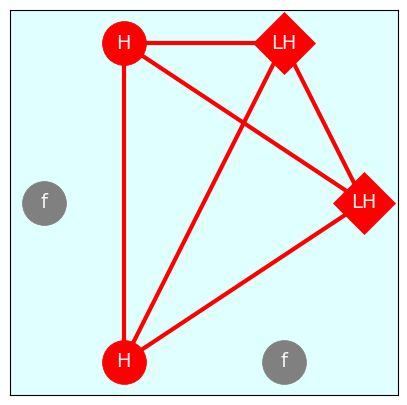

In [6]:
x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value

fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    x,
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()

### QUBO

In [7]:
tic = time.perf_counter()
Q, offset = build_qubo_matrix(mdl, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")


>>>> QUBO setup: 0.0001 seconds
>>>> BQM setup: 0.0002 seconds


In [8]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  12
Number of QUBO interactions:  64
Matrix sparsity:  0.9696969696969697
Energy offset: 696.0


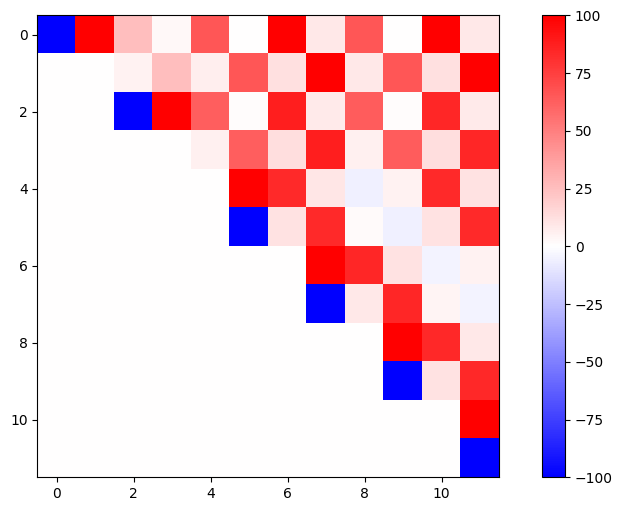

In [9]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [10]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=1_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  1.003385584015632


In [11]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  255.0
  max:  255.0
  median:  255.0
  mean:  255.0
  std:  0.0
Lowest solution:
  objective:  255.0
  probability:   1.0
  feasible:   False


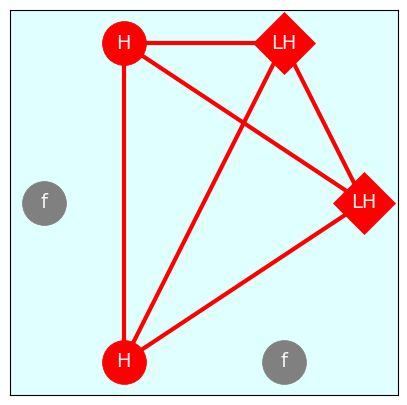

In [12]:
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()

## S_max = 2

In [13]:
max_num_segments = 2
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
)

Segmentation and Labeling Problem initialization:
  Number of nodes:  6
  Number of labels:  2
  Maximum number of segments:  2


### CPLEX

In [14]:
mdl = model.build_model()
mdl.solve()
mdl.print_information()
mdl.print_solution()

automatic C=max(B)= 116.0
Model: Segmentation and Labeling
 - number of variables: 24
   - binary=24, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: 10.000
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1
  x_4_1_0=1
  x_5_1_1=1


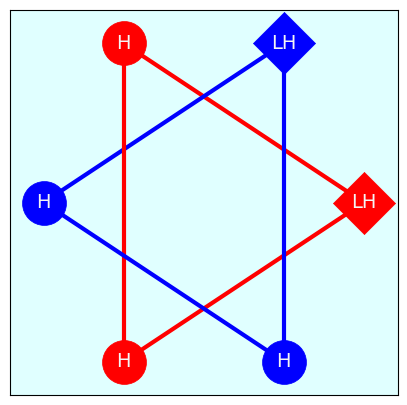

In [15]:
x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value

fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    x,
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()

### QUBO

In [16]:
tic = time.perf_counter()
Q, offset = build_qubo_matrix(mdl, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")


>>>> QUBO setup: 0.0002 seconds
>>>> BQM setup: 0.0002 seconds


In [17]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  24
Number of QUBO interactions:  152
Matrix sparsity:  0.5507246376811594
Energy offset: 696.0


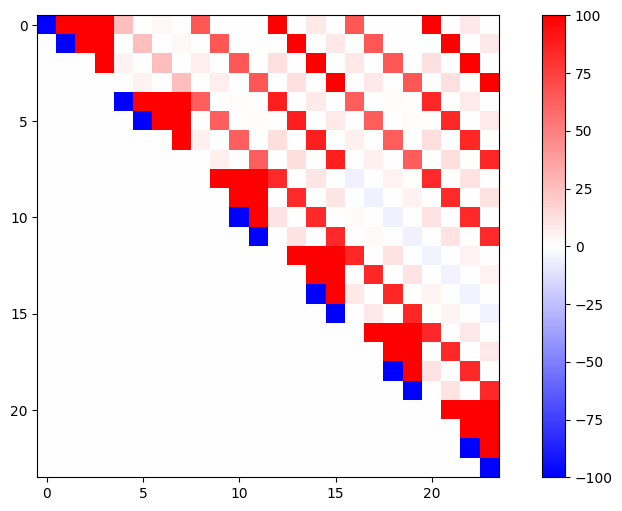

In [18]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [19]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=1_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  1.0034229999873787


In [20]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  10.0
  max:  10.0
  median:  10.0
  mean:  10.0
  std:  0.0
Lowest solution:
  objective:  10.0
  probability:   1.0
  feasible:   True


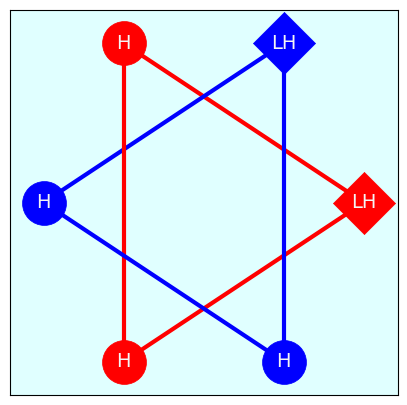

In [21]:
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()

## S_max = 3

In [22]:
max_num_segments = 3
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
)

Segmentation and Labeling Problem initialization:
  Number of nodes:  6
  Number of labels:  2
  Maximum number of segments:  3


### CPLEX

In [23]:
mdl = model.build_model()
mdl.solve()
mdl.print_information()
mdl.print_solution()

automatic C=max(B)= 116.0
Model: Segmentation and Labeling
 - number of variables: 36
   - binary=36, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -6.000
status: OPTIMAL_SOLUTION(2)
  x_0_0_2=1
  x_1_0_0=1
  x_2_1_2=1
  x_3_1_1=1
  x_4_1_2=1
  x_5_1_1=1


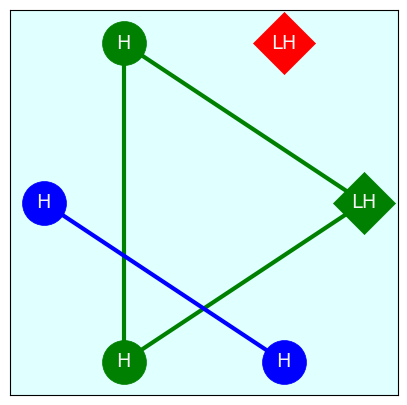

In [24]:
x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value

fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    x,
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()

### QUBO

In [25]:
tic = time.perf_counter()
Q, offset = build_qubo_matrix(mdl, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")


>>>> QUBO setup: 0.0003 seconds
>>>> BQM setup: 0.0003 seconds


In [26]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  36
Number of QUBO interactions:  264
Matrix sparsity:  0.41904761904761906
Energy offset: 696.0


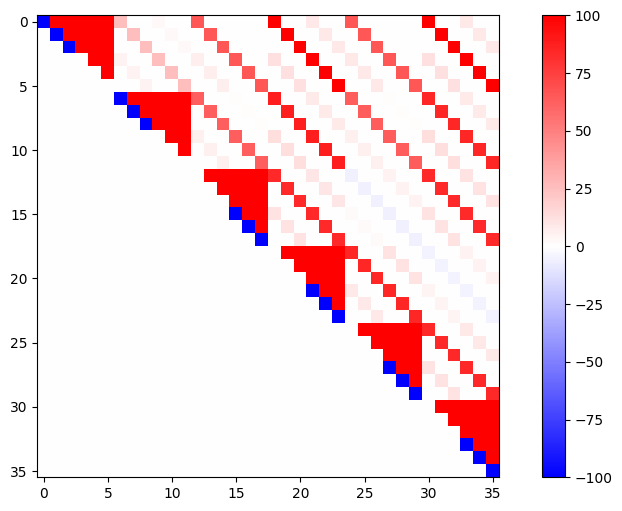

In [27]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [28]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=1_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  1.0025042080087587


In [29]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  -6.0
  max:  -6.0
  median:  -6.0
  mean:  -6.0
  std:  0.0
Lowest solution:
  objective:  -6.0
  probability:   1.0
  feasible:   True


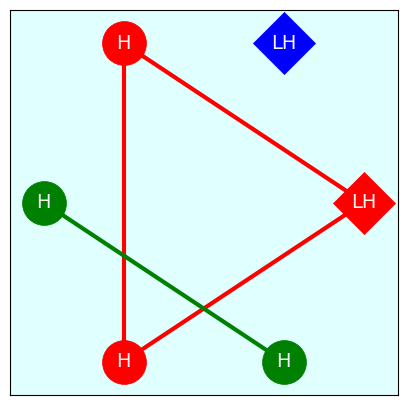

In [30]:
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=1000,
    width=3,
    alpha=1.0,
)
plt.show()